In [36]:
import random
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
from typing import Callable, Sequence
from scipy import stats 


# define your model.

In [2]:
def normal_model(params, edges, N):
    mu, sigma = params
    probs = norm.cdf(edges[1:], mu, sigma) - norm.cdf(edges[:-1], mu, sigma)
    return probs * N   # expected counts

# ------------------------------------------------------------
# 2) General Pearson χ² for binned data
# ------------------------------------------------------------

In [3]:
# General chi-square that calls the model
def chi2_func(params, observed, edges, model):
    expected = model(params, edges, observed.sum())
    mask = expected > 0
    return np.sum((observed[mask] - expected[mask])**2 / expected[mask])

###################################################################################
# Generate data
###################################################################################

In [18]:
mu1, sigma1 = 0, 1
nums = np.array([random.gauss(mu1, sigma1) for _ in range(100)])

# Bin the data
bin_edges = np.arange(min(nums), max(nums) + 0.05, 0.05)
counts, edges = np.histogram(nums, bins=bin_edges)

###################################################
# print the histogram 
###################################################

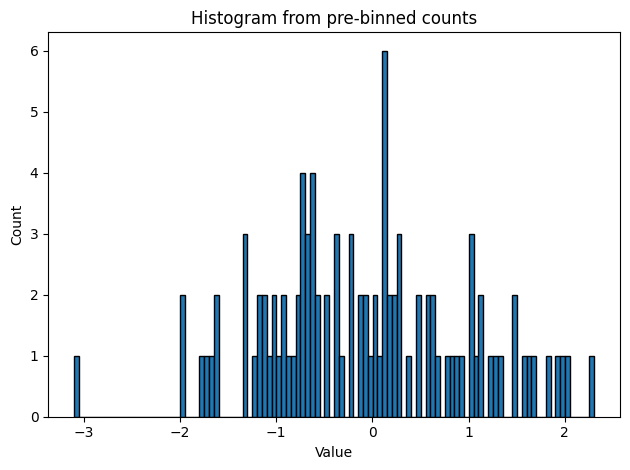

In [19]:
bin_widths  = edges[1:] - edges[:-1]
bin_centers = edges[:-1] + bin_widths/2

plt.figure()
plt.bar(bin_centers, counts, width=bin_widths, align='center', edgecolor='k')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram from pre-binned counts')
plt.tight_layout()
plt.show()

###################################################################################
# Minimize χ²
###################################################################################

In [20]:
result = opt.minimize(lambda p: chi2_func(p, counts, edges, normal_model),[0, 1],
                      bounds=[(-5, 5), (0.1, 5)])

best_mu, best_sigma = result.x

print("Best fit μ:", best_mu)
print("Best fit σ:", best_sigma)

Best fit μ: -0.1521898524268351
Best fit σ: 1.2738913030713162


# plot the chi square and mini minimized point.

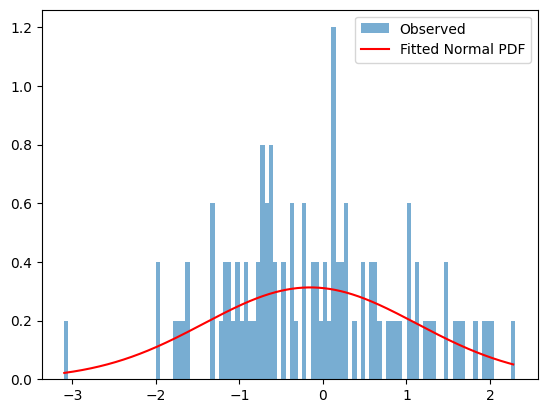

In [21]:

plt.hist(nums, bins=bin_edges, density=True, alpha=0.6, label="Observed")
x = np.linspace(min(nums), max(nums), 500)
plt.plot(x, norm.pdf(x, best_mu, best_sigma), 'r-', label="Fitted Normal PDF")
plt.legend()
plt.show()

In [22]:
print(chi2_values)

[np.float64(2406.1729931231093), np.float64(2165.182194878213), np.float64(1951.2133356924107), np.float64(1760.977898800137), np.float64(1591.6150039115746), np.float64(1440.632762938275), np.float64(1305.8580546848877), np.float64(1185.3934613677427), np.float64(1077.5803042211567), np.float64(980.9668788036789), np.float64(894.2811280848334), np.float64(816.407107151309), np.float64(746.3646909831689), np.float64(683.2920591233352), np.float64(626.4305606587375), np.float64(575.1116217877802), np.float64(528.7454080748842), np.float64(486.81099571795977), np.float64(448.8478419737798), np.float64(414.4483753040407), np.float64(383.25155166073864), np.float64(354.9372453314838), np.float64(329.2213615064886), np.float64(305.85157371017374), np.float64(284.60360288101543), np.float64(265.27796654044886), np.float64(247.69713646349712), np.float64(231.70305180404984), np.float64(217.15494195086768), np.float64(203.9274196770824), np.float64(191.9088105506339), np.float64(180.9996892258

# -----------------------------
# χ² contour over (mu, sigma)
# -----------------------------

/tmp/ipykernel_108940/2872775307.py:27: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(best_mu, best_sigma, marker='x', s=90, c='white', edgecolor='k', label='χ² minimum')


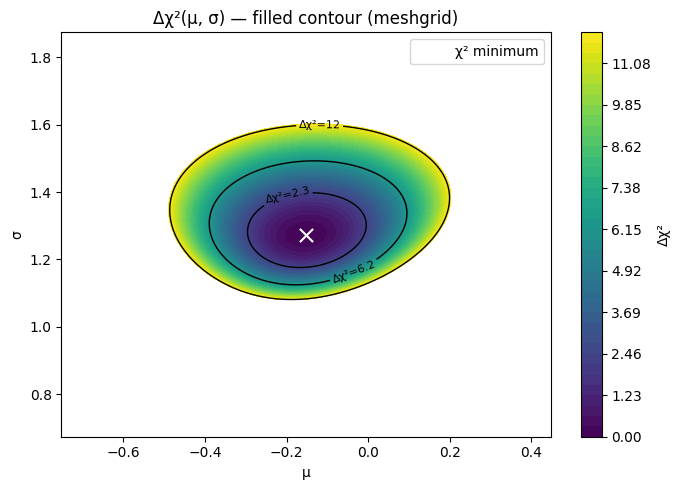

In [25]:
dmu = 0.6
dsig_low, dsig_high = 0.6, 0.6  # asymmetric margins are fine too
mu_grid    = np.linspace(best_mu - dmu, best_mu + dmu, 200)
sig_grid   = np.linspace(max(0.15, best_sigma - dsig_low), best_sigma + dsig_high, 200)
MU, SIG = np.meshgrid(mu_grid, sig_grid, indexing='xy')

# 2) Evaluate chi-square on the grid (meshgrid)
CHI2 = np.empty_like(MU)
for i in range(MU.shape[0]):
    for j in range(MU.shape[1]):
        CHI2[i, j] = chi2_func([MU[i, j], SIG[i, j]], counts, edges, normal_model)

# 3) Convert to Δχ² so the colormap is not crushed by far-away huge values
chi2_min = np.nanmin(CHI2)
dCHI2 = CHI2 - chi2_min

# 4) Plot FILLED contours (colors), not just lines
plt.figure(figsize=(7,5))
# choose a sensible top—12 is standard to include ~3σ for 2 params
levels = np.linspace(0, 12, 40)
cf = plt.contourf(MU, SIG, dCHI2, levels=levels, cmap="viridis")
# draw the canonical confidence contours
cs = plt.contour(MU, SIG, dCHI2, levels=[2.3, 6.17, 11.8], colors='k', linewidths=1)
plt.clabel(cs, fmt=lambda v: f"Δχ²={v:.2g}", inline=True, fontsize=8)

# mark the minimum
plt.scatter(best_mu, best_sigma, marker='x', s=90, c='white', edgecolor='k', label='χ² minimum')

plt.xlabel('μ')
plt.ylabel('σ')
plt.title('Δχ²(μ, σ) — filled contour (meshgrid)')
plt.legend()
cbar = plt.colorbar(cf)
cbar.set_label('Δχ²')
plt.tight_layout()
plt.show()

# -----------------------------
# F-test for equality of variances (two-sided)
# H0: sigma1^2 == sigma2^2   vs   H1: sigma1^2 != sigma2^2
# Assumes independent Normal samples.
# -----------------------------

In [38]:
def ftest_equal_var(x, y):
    # lengths of the two samples
    n1, n2 = len(x), len(y)
    # unbiased sample variances (ddof=1 means divide by n-1)
    s1_sq = np.var(x, ddof=1)
    s2_sq = np.var(y, ddof=1)

    # Convention: put the larger variance in the numerator so F >= 1
    if s1_sq >= s2_sq:
        F = s1_sq / s2_sq
        df1, df2 = n1 - 1, n2 - 1   # degrees of freedom
    else:
        F = s2_sq / s1_sq
        df1, df2 = n2 - 1, n1 - 1

    # cumulative probability under the F distribution
    cdf_val = stats.f.cdf(F, df1, df2)
    # two-sided p-value = probability in the tail areas on both sides
    p_two_sided = 2 * min(cdf_val, 1 - cdf_val)

    # return all useful numbers
    return F, df1, df2, p_two_sided, s1_sq, s2_sq

# -----------------------------
# Repeat the F-test for different sample sizes
# -----------------------------

In [42]:
rng = np.random.default_rng(42)  # reproducible random numbers

# population parameters
mu1, sigma1 = 0.0, 1.0
mu2, sigma2 = 0.0, 1.0   # change sigma2 to 1.5 if you want unequal variances

for n in [10, 30, 100, 300]:
    # generate two random samples from Normal distributions
    x = rng.normal(mu1, sigma1, size=n)
    y = rng.normal(mu2, sigma2, size=n)

    # run the F-test
    F, df1, df2, p, s1_sq, s2_sq = ftest_equal_var(x, y)
    print(f"  n = {n}")
    print(f"  sample variances: s1^2 = {s1_sq:.4f},  s2^2 = {s2_sq:.4f}")
    print(f"  F = {F:.4f}  with df1 = {df1}, df2 = {df2}")
    print(f"  two-sided p-value = {p:.4f}")
    print("  decision @ α=0.05:", "reject H0 (variances differ)" if p < 0.05 else "fail to reject H0")
    print()

  n = 10
  sample variances: s1^2 = 0.8714,  s2^2 = 0.5236
  F = 1.6642  with df1 = 9, df2 = 9
  two-sided p-value = 0.4597
  decision @ α=0.05: fail to reject H0

  n = 30
  sample variances: s1^2 = 0.4835,  s2^2 = 0.6165
  F = 1.2752  with df1 = 29, df2 = 29
  two-sided p-value = 0.5169
  decision @ α=0.05: fail to reject H0

  n = 100
  sample variances: s1^2 = 0.8718,  s2^2 = 1.0673
  F = 1.2242  with df1 = 99, df2 = 99
  two-sided p-value = 0.3158
  decision @ α=0.05: fail to reject H0

  n = 300
  sample variances: s1^2 = 0.9910,  s2^2 = 1.0614
  F = 1.0711  with df1 = 299, df2 = 299
  two-sided p-value = 0.5531
  decision @ α=0.05: fail to reject H0



# Generate using a sequence of 10^2 uniformly distributed random numbers xi between 0−1, compute the distribution of yi = 2(xi −0.5). Use χ2 to determine the best fit values for μ and σ by fitting a normal distribution to this data. Repeat the last problem for yi = 0.01/(xi −0.5)

In [43]:
# -----------------------------
# Step 1: Generate uniform data and transform
# -----------------------------
rng = np.random.default_rng(42)
x = rng.uniform(0, 1, 100)         # uniform [0,1]
y = 2 * (x - 0.5)                  # transform

# -----------------------------
# Step 2: Bin data (like before)
# -----------------------------
bin_width = 0.05
edges = np.arange(y.min(), y.max() + bin_width, bin_width)
counts, _ = np.histogram(y, bins=edges)

In [44]:
print("Uniform random numbers x:\n", x)
print("\nTransformed data y = 2(x - 0.5):\n", y)

Uniform random numbers x:
 [0.77395605 0.43887844 0.85859792 0.69736803 0.09417735 0.97562235
 0.7611397  0.78606431 0.12811363 0.45038594 0.37079802 0.92676499
 0.64386512 0.82276161 0.4434142  0.22723872 0.55458479 0.06381726
 0.82763117 0.6316644  0.75808774 0.35452597 0.97069802 0.89312112
 0.7783835  0.19463871 0.466721   0.04380377 0.15428949 0.68304895
 0.74476216 0.96750973 0.32582536 0.37045971 0.46955581 0.18947136
 0.12992151 0.47570493 0.22690935 0.66981399 0.43715192 0.8326782
 0.7002651  0.31236664 0.8322598  0.80476436 0.38747838 0.2883281
 0.6824955  0.13975248 0.1999082  0.00736227 0.78692438 0.66485086
 0.70516538 0.78072903 0.45891578 0.5687412  0.139797   0.11453007
 0.66840296 0.47109621 0.56523611 0.76499886 0.63471832 0.5535794
 0.55920716 0.3039501  0.03081783 0.43671739 0.21458467 0.40852864
 0.85340307 0.23393949 0.05830274 0.28138389 0.29359376 0.66191651
 0.55703215 0.78389821 0.66431354 0.40638686 0.81402038 0.16697292
 0.02271207 0.09004786 0.72235935 0.46

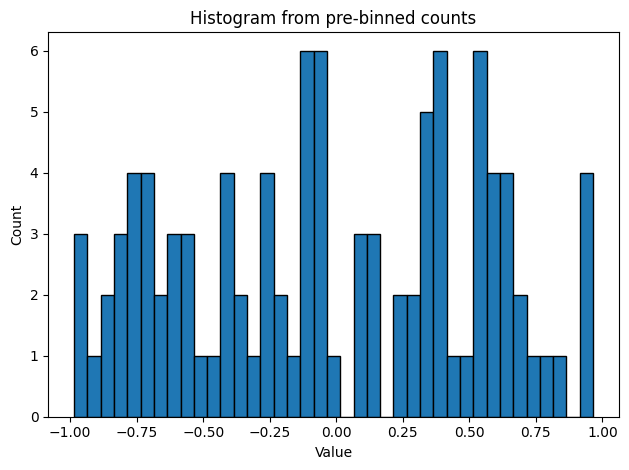

In [45]:
bin_widths  = edges[1:] - edges[:-1]
bin_centers = edges[:-1] + bin_widths/2

plt.figure()
plt.bar(bin_centers, counts, width=bin_widths, align='center', edgecolor='k')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram from pre-binned counts')
plt.tight_layout()
plt.show()

# X2 minimize


In [46]:
result = opt.minimize(lambda p: chi2_func(p, counts, edges, normal_model),[0, 1],
                      bounds=[(-5, 5), (0.1, 5)])

best_mu, best_sigma = result.x

print("Best fit μ:", best_mu)
print("Best fit σ:", best_sigma)

Best fit μ: 0.0056171747514616515
Best fit σ: 0.6724531134189329


#  chi-square minimization and best fit

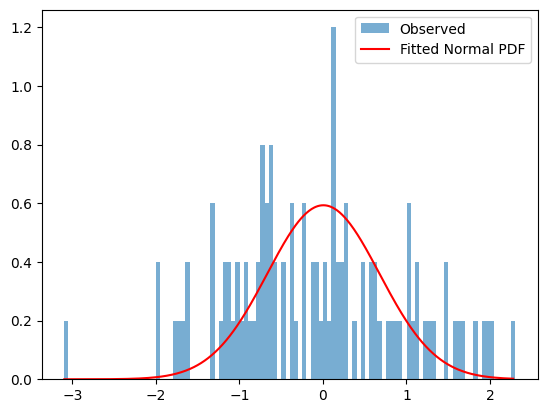

In [47]:

plt.hist(nums, bins=bin_edges, density=True, alpha=0.6, label="Observed")
x = np.linspace(min(nums), max(nums), 500)
plt.plot(x, norm.pdf(x, best_mu, best_sigma), 'r-', label="Fitted Normal PDF")
plt.legend()
plt.show()

# using yi = 0.01/(xi −0.5)

In [51]:
# -----------------------------
# Step 1: Generate uniform data and transform
# -----------------------------
rng = np.random.default_rng(42)
x = rng.uniform(0, 1, 100)         # uniform [0,1]
y = 0.01 * (x - 0.5)                  # transform

# -----------------------------
# Step 2: Bin data (like before)
# -----------------------------
bin_width = 0.05
edges = np.arange(y.min(), y.max() + bin_width, bin_width)
counts, _ = np.histogram(y, bins=edges)

print("Uniform random numbers x:\n", x)
print("\nTransformed data y = 0.01(x - 0.5):\n", y)

Uniform random numbers x:
 [0.77395605 0.43887844 0.85859792 0.69736803 0.09417735 0.97562235
 0.7611397  0.78606431 0.12811363 0.45038594 0.37079802 0.92676499
 0.64386512 0.82276161 0.4434142  0.22723872 0.55458479 0.06381726
 0.82763117 0.6316644  0.75808774 0.35452597 0.97069802 0.89312112
 0.7783835  0.19463871 0.466721   0.04380377 0.15428949 0.68304895
 0.74476216 0.96750973 0.32582536 0.37045971 0.46955581 0.18947136
 0.12992151 0.47570493 0.22690935 0.66981399 0.43715192 0.8326782
 0.7002651  0.31236664 0.8322598  0.80476436 0.38747838 0.2883281
 0.6824955  0.13975248 0.1999082  0.00736227 0.78692438 0.66485086
 0.70516538 0.78072903 0.45891578 0.5687412  0.139797   0.11453007
 0.66840296 0.47109621 0.56523611 0.76499886 0.63471832 0.5535794
 0.55920716 0.3039501  0.03081783 0.43671739 0.21458467 0.40852864
 0.85340307 0.23393949 0.05830274 0.28138389 0.29359376 0.66191651
 0.55703215 0.78389821 0.66431354 0.40638686 0.81402038 0.16697292
 0.02271207 0.09004786 0.72235935 0.46

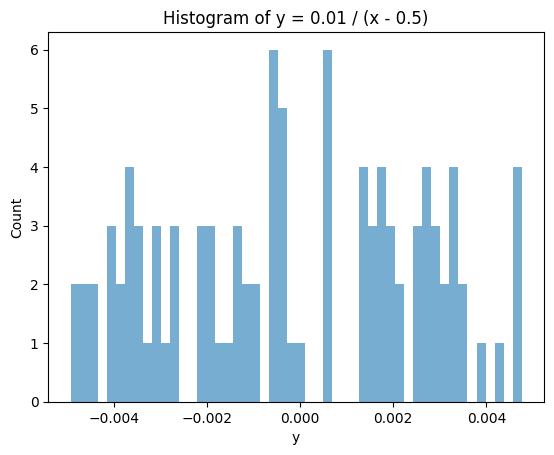

In [54]:
bin_widths  = edges[1:] - edges[:-1]
bin_centers = edges[:-1] + bin_widths/2

plt.figure()
# plt.bar(bin_centers, counts, width=bin_widths, align='center', edgecolor='k')
# plt.xlabel('Value')
# plt.ylabel('Count')
# plt.title('Histogram from pre-binned counts')
# plt.tight_layout()
# plt.show()

plt.hist(y, bins=50, alpha=0.6)
plt.xlabel("y")
plt.ylabel("Count")
plt.title("Histogram of y = 0.01 / (x - 0.5)")
plt.show()


Best fit μ: 5.0
Best fit σ: 0.1


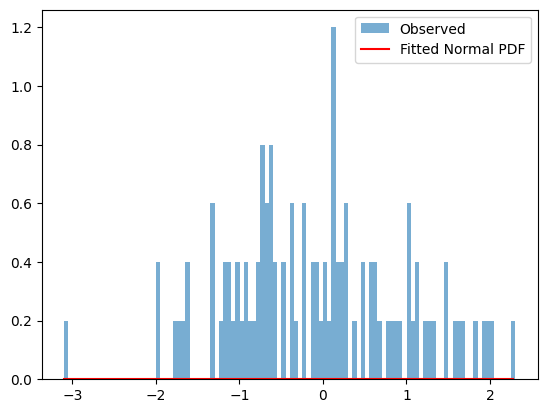

In [55]:
result = opt.minimize(lambda p: chi2_func(p, counts, edges, normal_model),[0, 1],
                      bounds=[(-5, 5), (0.1, 5)])

best_mu, best_sigma = result.x

print("Best fit μ:", best_mu)
print("Best fit σ:", best_sigma)


plt.hist(nums, bins=bin_edges, density=True, alpha=0.6, label="Observed")
x = np.linspace(min(nums), max(nums), 500)
plt.plot(x, norm.pdf(x, best_mu, best_sigma), 'r-', label="Fitted Normal PDF")
plt.legend()
plt.show()
